# Orientation

In this notebook we look into **Orientation**, a shape descriptor, tailored to plan description. Once we have extracted the **skeleton** of a given floor plan's walls, we aggregate the length of walls in each of the 360 directions of space.
As a result, we obtain a polar diagram, reflecting the overall orientation of a given floor plan.

Reference: https://matplotlib.org/examples/pylab_examples/polar_demo.html

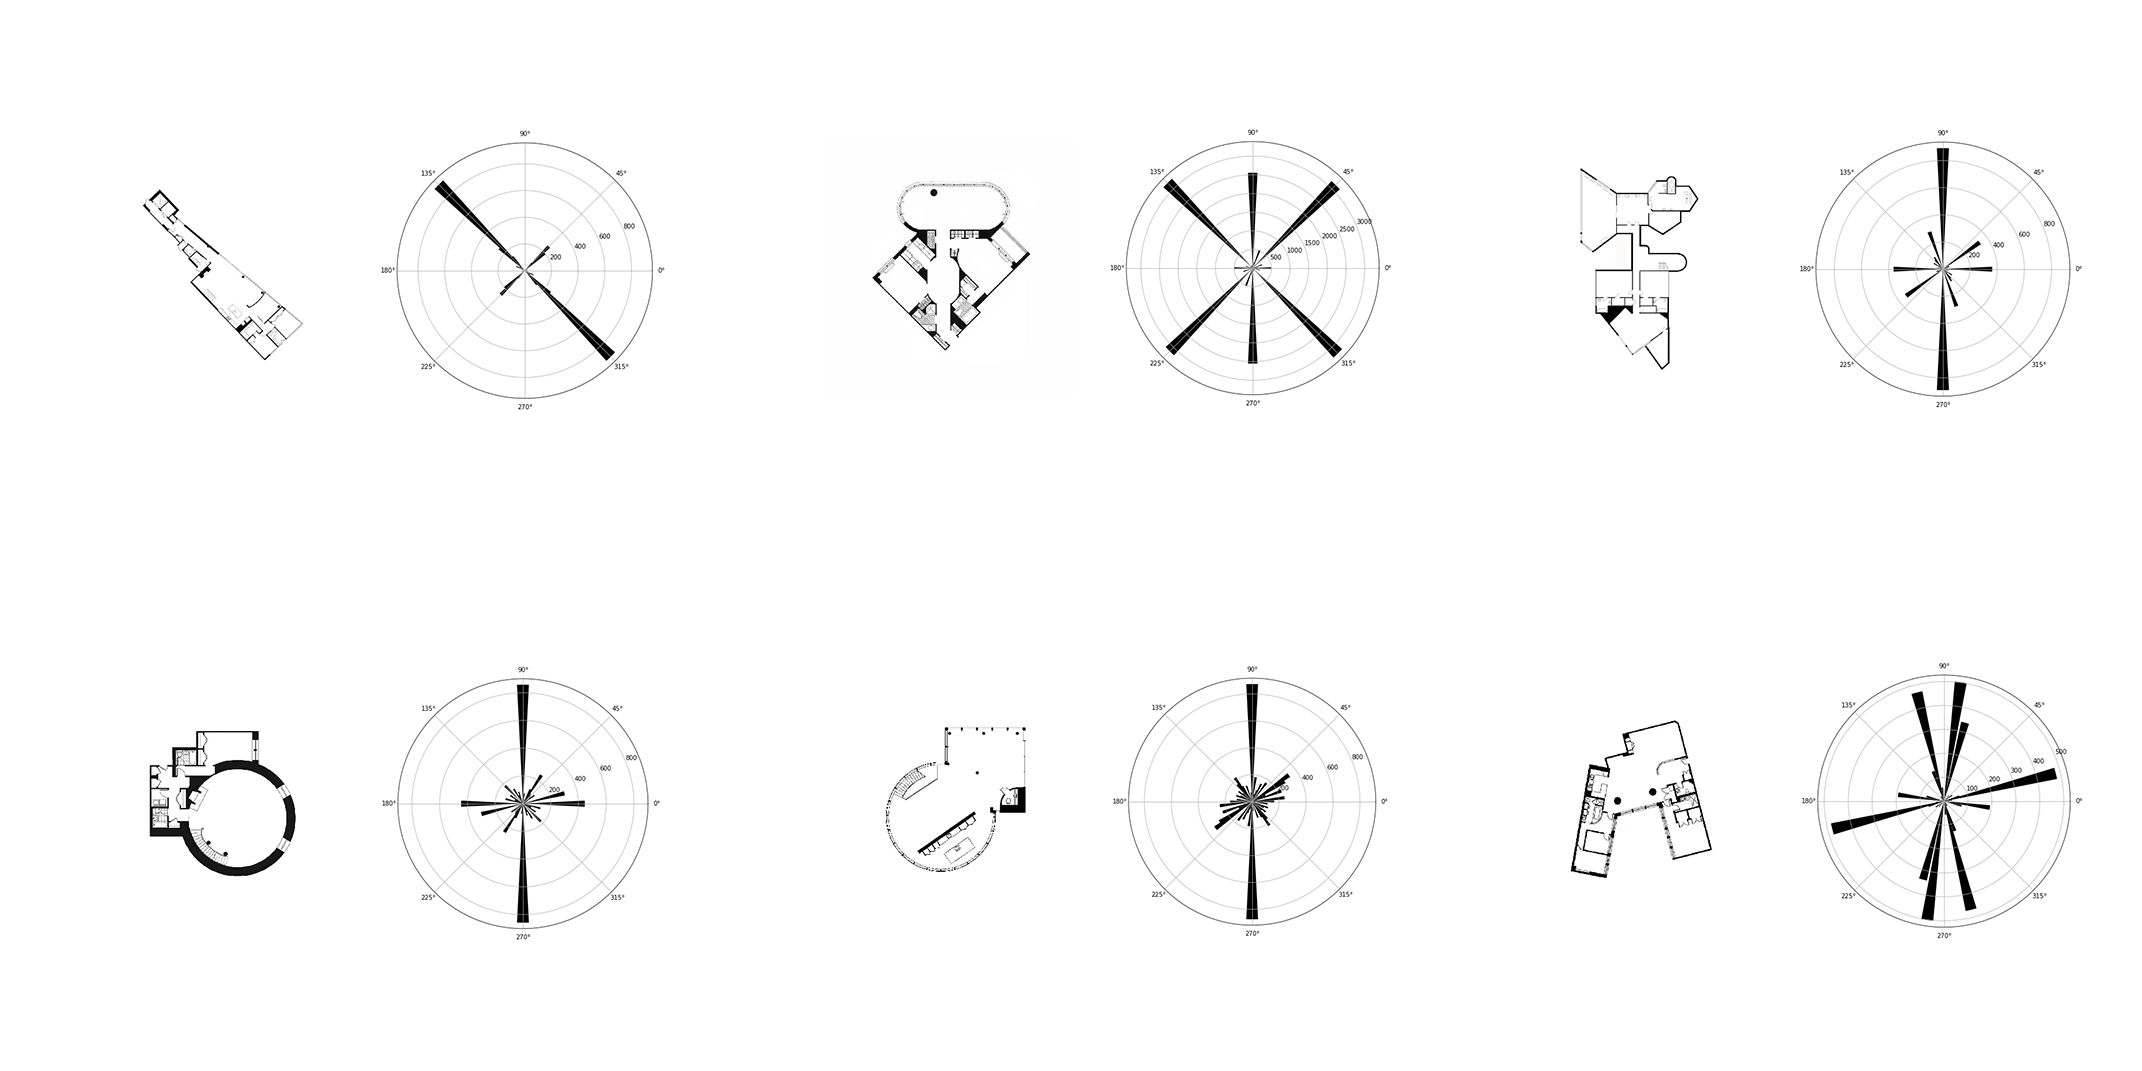

In [2]:
from IPython.display import Image
Image(filename='IMG/orientation.png',width=1200, height=300)

In [2]:
import pandas as pd
import cairo
import matplotlib.pylab as plt
import math
from IPython.display import Image
import numpy as np
from numpy import *
import glob
import os
import os.path
import time
import cv2
import random
import ast
from PIL import Image
from math import *
import networkx as nx
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc
from scipy.ndimage.interpolation import geometric_transform
from skimage.morphology import skeletonize
from skimage import data
import sknw
import random
from shapely.geometry import LineString

### Utility Functions

In [5]:
def get_skeleton(img_2,print_):
    # open and skeletonize
    img = np.abs(np.round(img_2[:,:,0]/255).astype(np.int)-1)
    img_white = np.round(img_2[:,:,0]/255).astype(np.int)
    ske = skeletonize(img).astype(np.uint16)

    # build graph from skeleton
    graph = sknw.build_sknw(ske)

    if(print_==True):
        plt.figure(figsize=(10,10))

    # draw edges by pts
    if(print_==True):
        for (s,e) in graph.edges():
            ps = graph[s][e]['pts']
            plt.plot(ps[:,1], ps[:,0], 'black')


    # draw node by o
    node, nodes = graph.node, graph.nodes()
   
    if(print_==True):
        plt.title('Skeleton')
        plt.axis("off")
        plt.show()
    
    return graph, img_white

In [6]:
def get_len(x1,y1,x2,y2):
    length = math.sqrt((x2-x1)**2+(y2-y1)**2)
    return length

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.abs(np.rad2deg((ang1 - ang2))+90)

def get_orientation_graph(img_white, graph, print_, save_,im_id):
    
    #get all edges
    edges_list = [graph[s][e]['pts'] for (s,e) in graph.edges()]
    
    if(print_==True):
        fig = plt.figure(figsize=(16, 12))
        ax1 = fig.add_subplot(121)
        ax1.imshow(img_white, interpolation='None')
        ax1.axis("off")

    angles = []
    length_ = []
    failed = 0
    index_ = []
    for i in range(len(edges_list)):
        try:
            #get length edge
            ps = edges_list[i]
            y_min = ps[:,1][0]
            x_min = ps[:,0][0]
            y_max = ps[:,1][-1]
            x_max = ps[:,0][-1]
            length_.append(get_len(x_min,y_min,x_max,y_max))

            #get mid point
            ps_midpoint = ps[int(len(ps)/2)]
            point_sample_id = 4
            
            
            val_min = np.argmin([ ps[:,1][int(len(ps)/2)-point_sample_id] ,ps[:,1][int(len(ps)/2)+point_sample_id] ])
            
            if(val_min==0):
                i_ = int(len(ps)/2)-point_sample_id
                x__min= ps[:,0][i_]
                y__min= ps[:,1][i_]
            
            if(val_min==1):
                i_ = int(len(ps)/2)+point_sample_id
                x__min= ps[:,0][i_]
                y__min= ps[:,1][i_]
            
            s_pt = [ps[:,0][int(len(ps)/2)-point_sample_id] - x__min,ps[:,1][int(len(ps)/2)-point_sample_id] - y__min]
            e_pt = [ps[:,0][int(len(ps)/2)+point_sample_id] - x__min,ps[:,1][int(len(ps)/2)+point_sample_id] - y__min]

            angles.append(angle_between(e_pt, s_pt))
            index_.append(i)

        except:
            failed = failed+1
    
    angles = np.array(angles).astype(int)
    unique_angles, counts = np.unique(angles, return_counts=True)

    length_selected = np.array(length_)[index_]

    cumulative_sum = []
    for ang in unique_angles:
        cumulative_sum.append(np.sum(length_selected[angles==ang]))

    #add 0 and 180 and delete 180
    try:
        id_180 = np.where(unique_angles==180)[0][0]
        id_0 = np.where(unique_angles==0)[0][0]
        unique_angles = np.delete(unique_angles,id_180)
        cumulative_sum = np.delete(cumulative_sum,id_180)
    except:
        pass

    #double values for 180 to 360
    u_a = np.append(unique_angles,unique_angles+180)*2*np.pi/360
    radius = np.append(cumulative_sum,cumulative_sum) 

    if(print_==True):
        #print polar diagram
        ax2 = fig.add_subplot(122, polar=True)
        bars = ax2.bar(u_a, radius, width=0.1, bottom=0.2, color="black")
    if(save_==True):
        plt.savefig('IMG/orientation/'+str(im_id+1)+'.png')
    if(print_==True):
        plt.show()


    return (u_a/np.pi*360/2).astype(int), radius

### Application

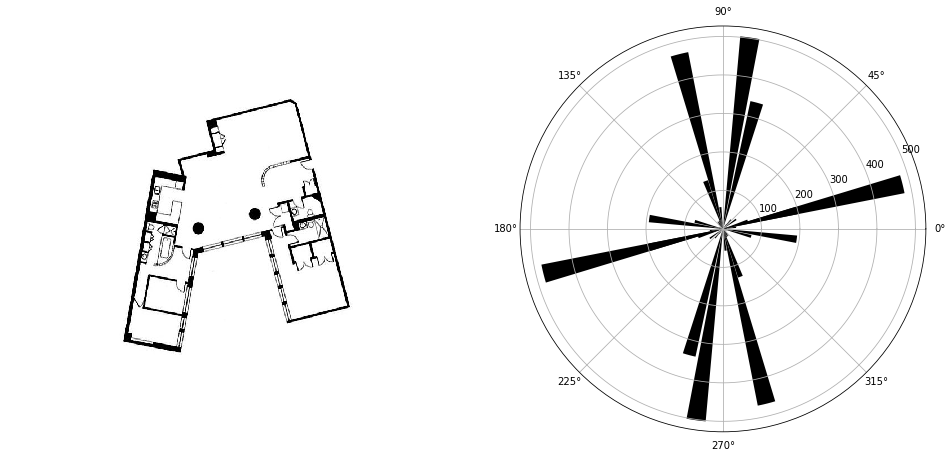

In [12]:
img_names = os.listdir("IMG/terrible_plans/")
im = cv2.imread("IMG/terrible_plans/"+img_names[4])
graph_, image_ = get_skeleton(im,print_=False) 
unique_angles, cumulative_sum = get_orientation_graph(im, graph_, print_=True,save_=True,im_id=1)

### Batch processing

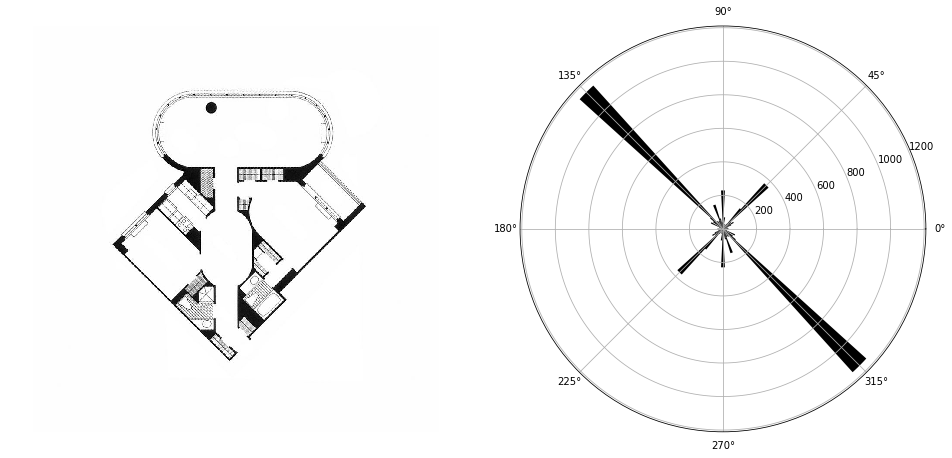

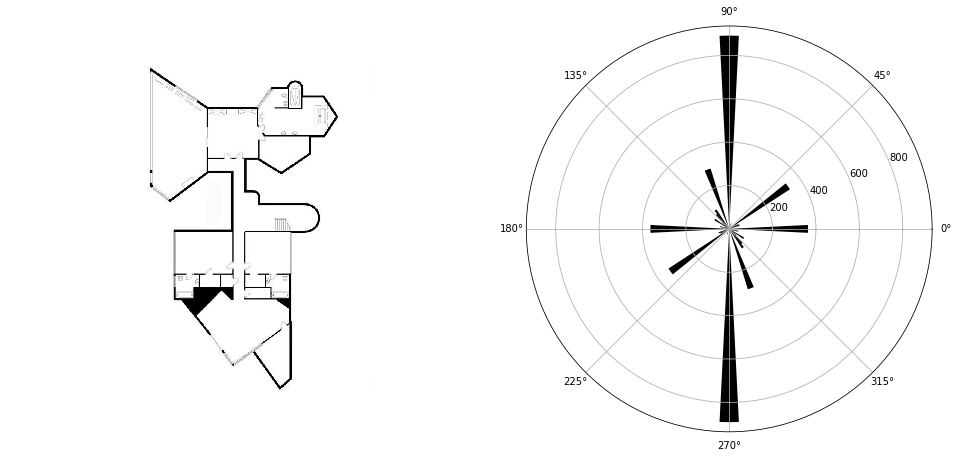

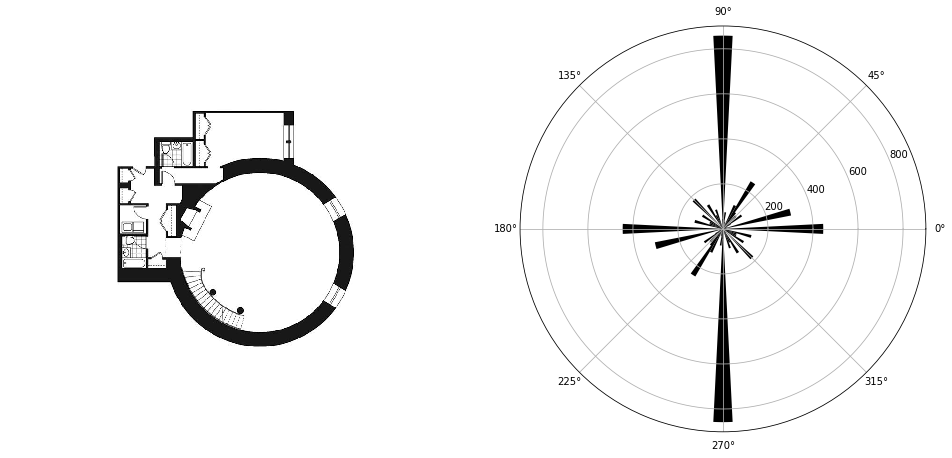

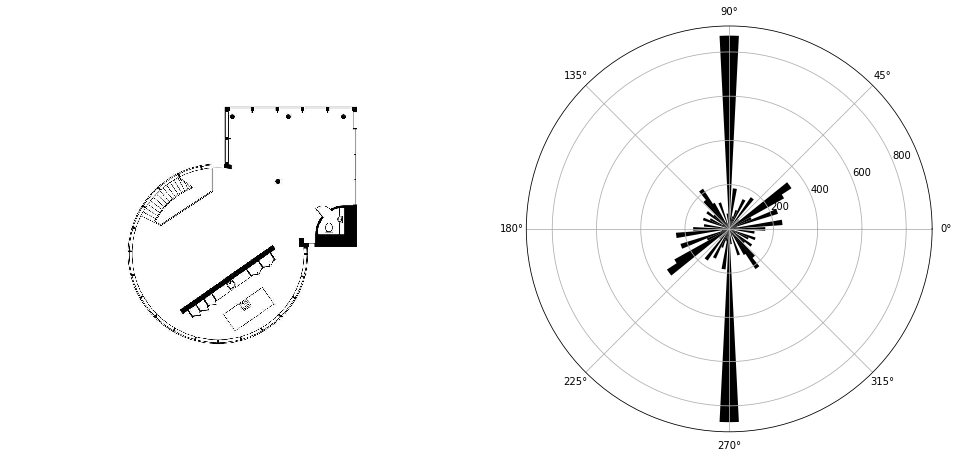

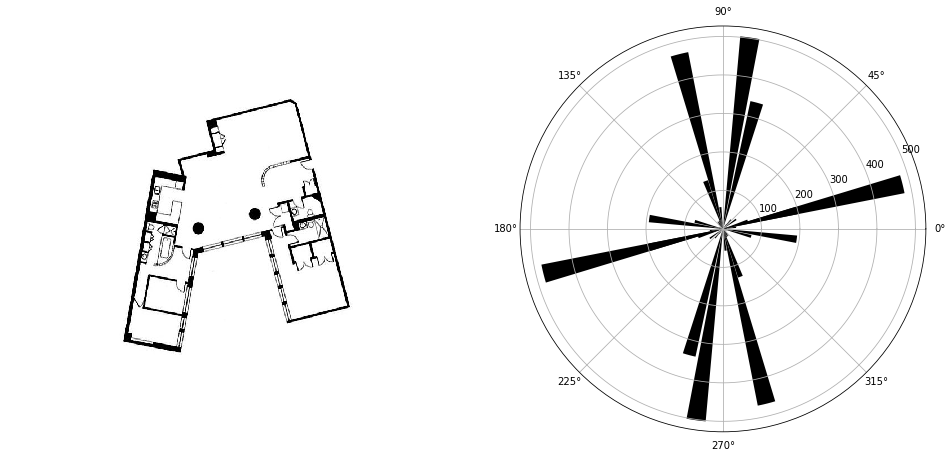

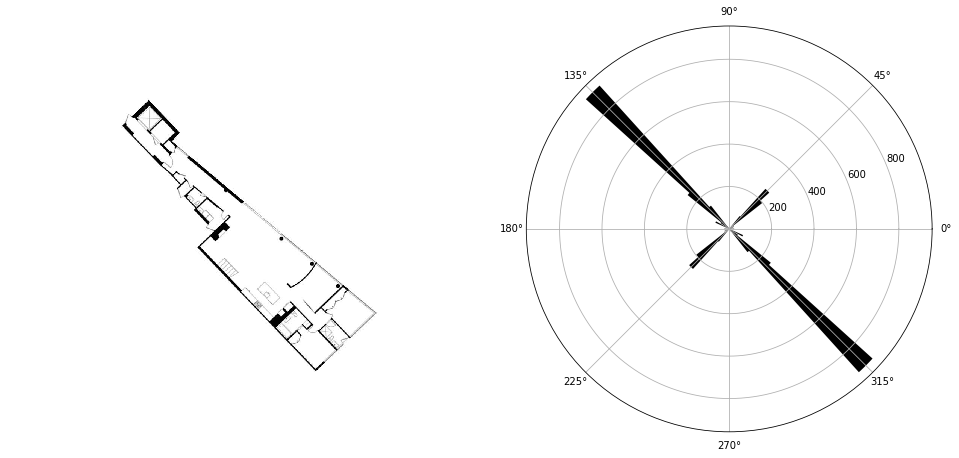

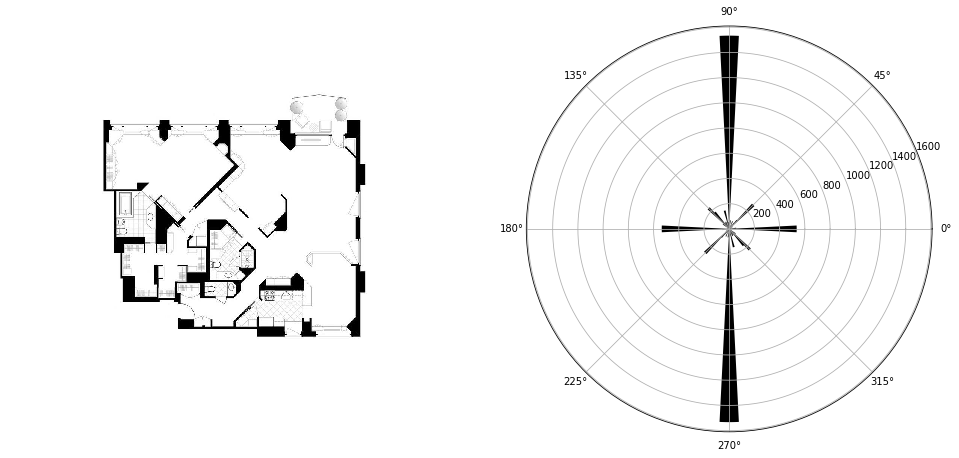

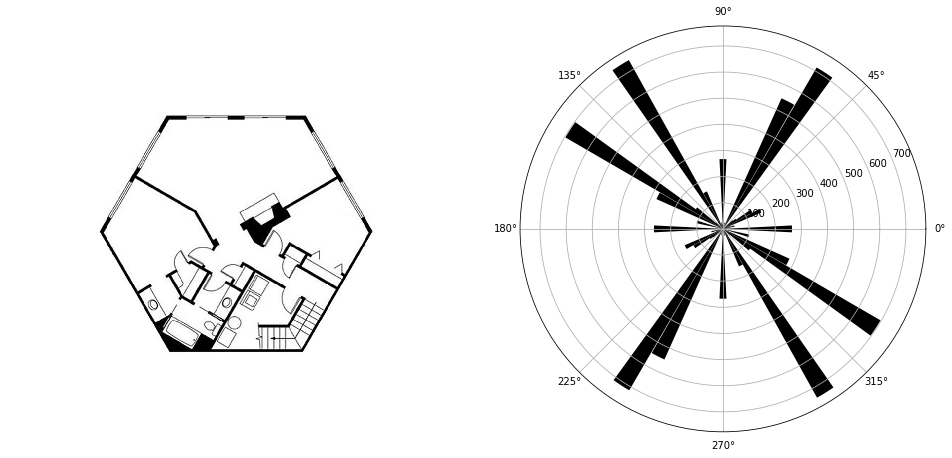

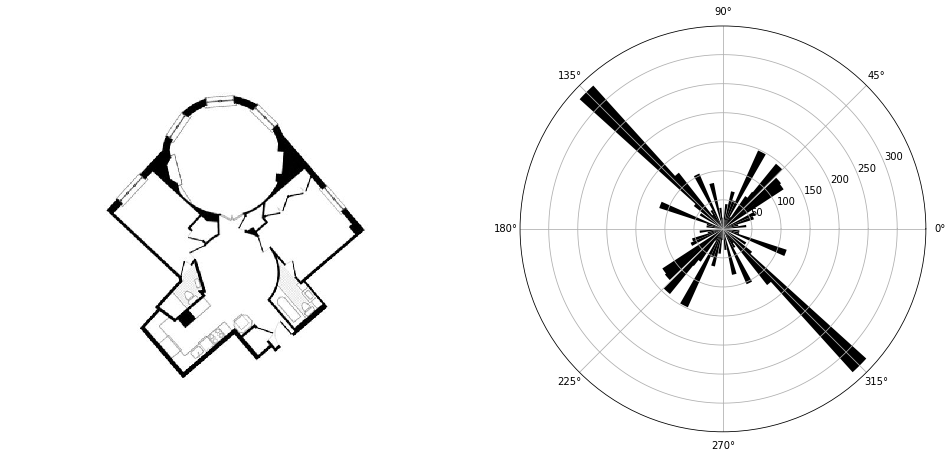

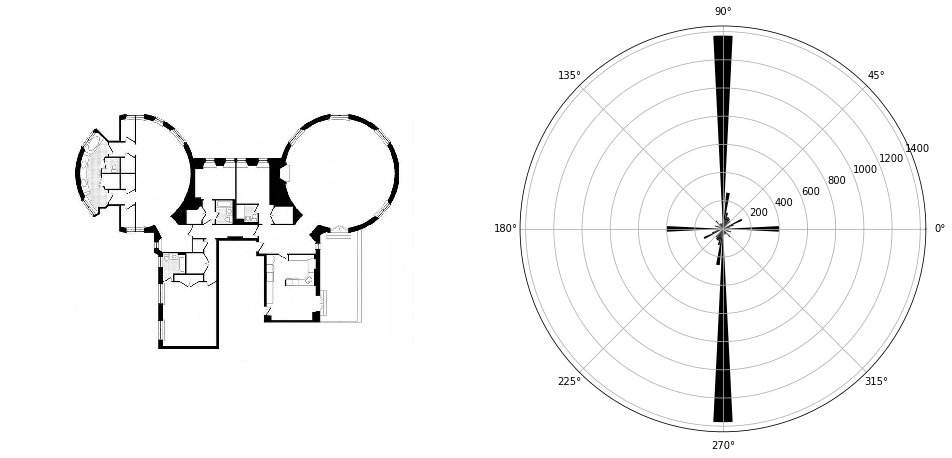

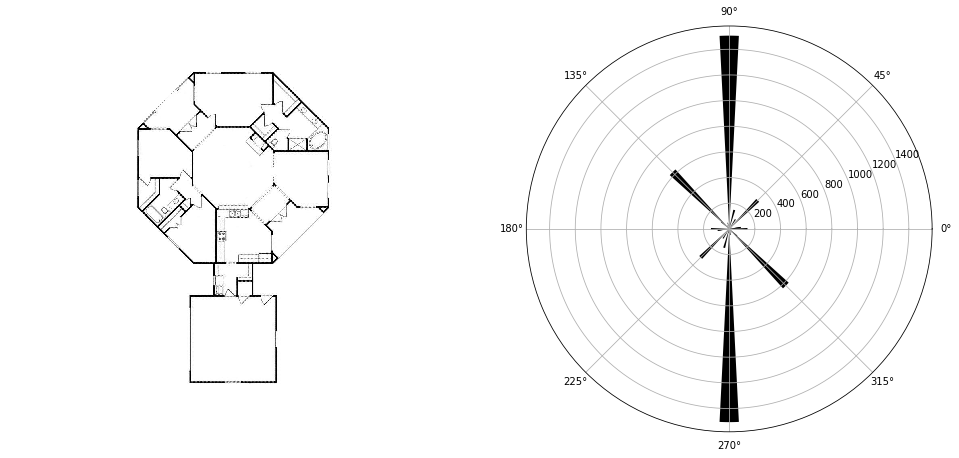

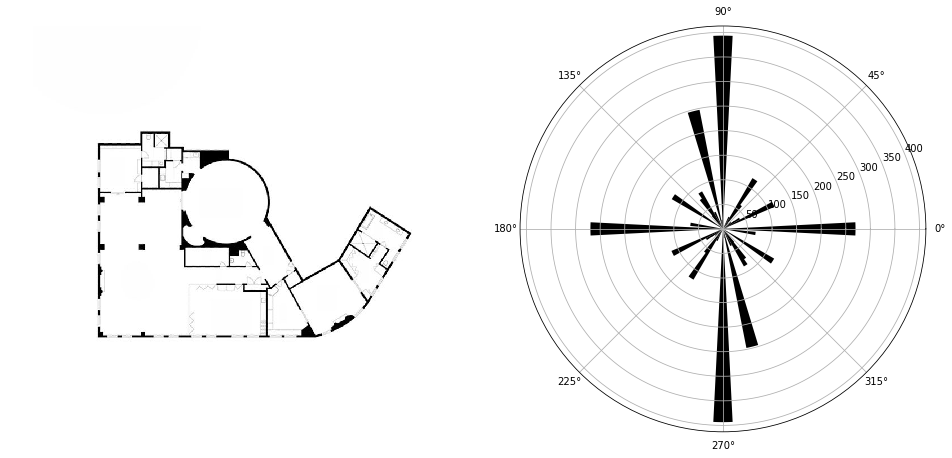

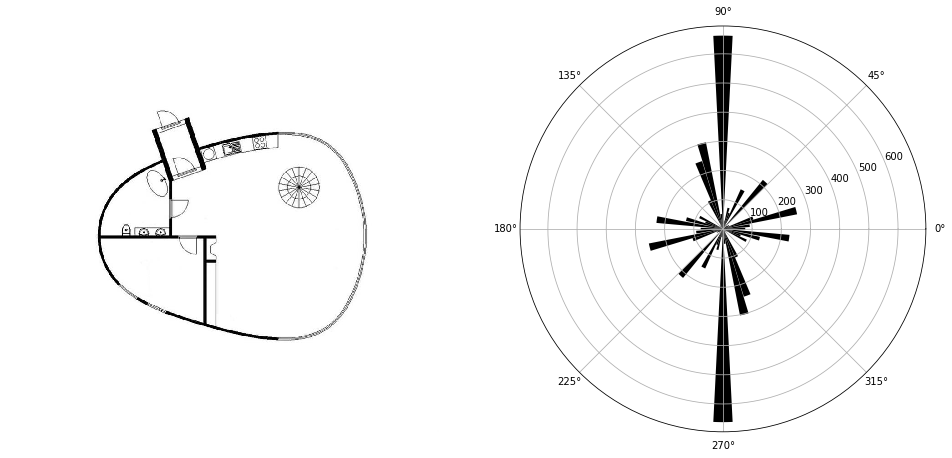

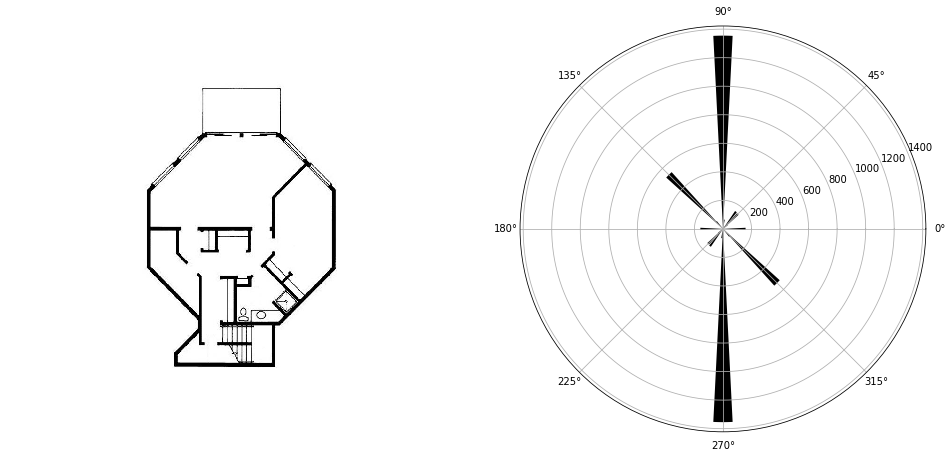

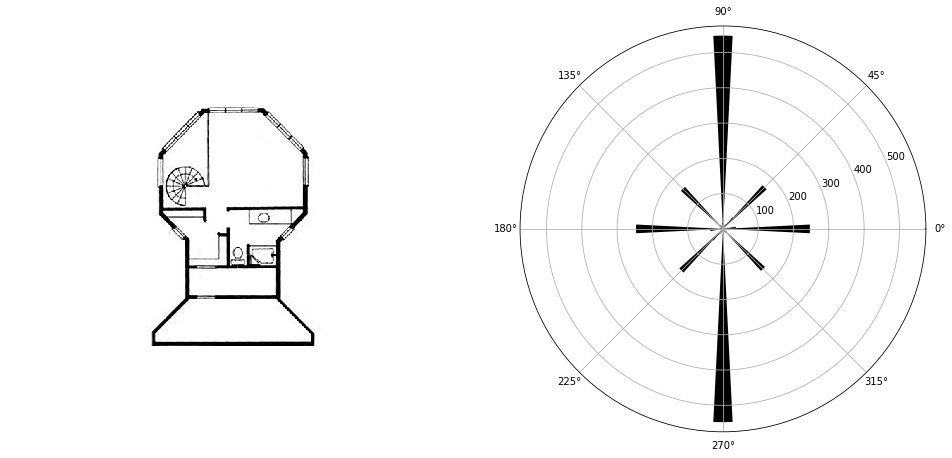

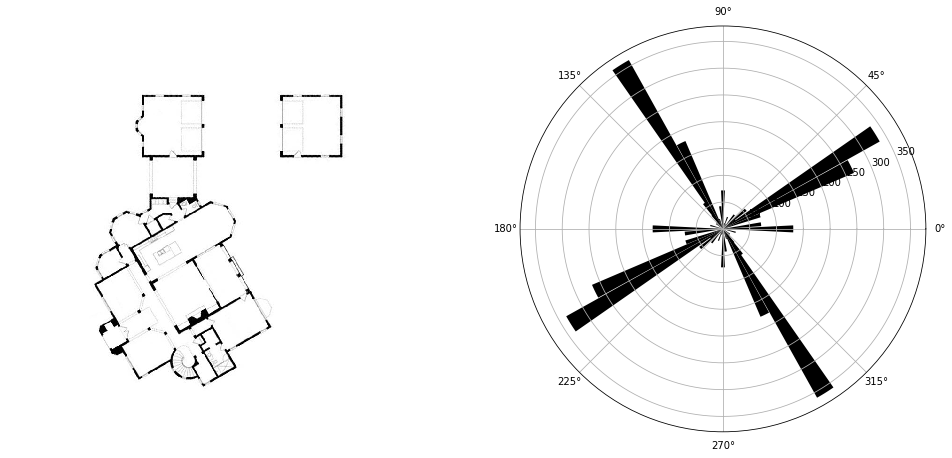

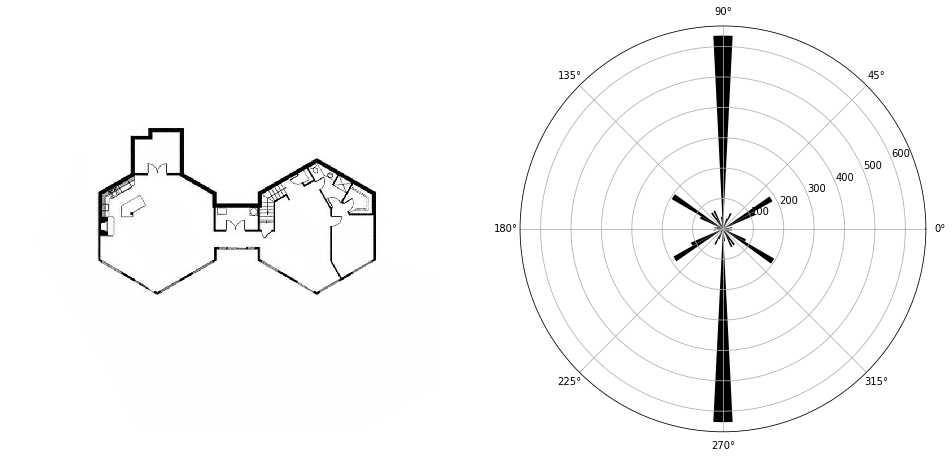

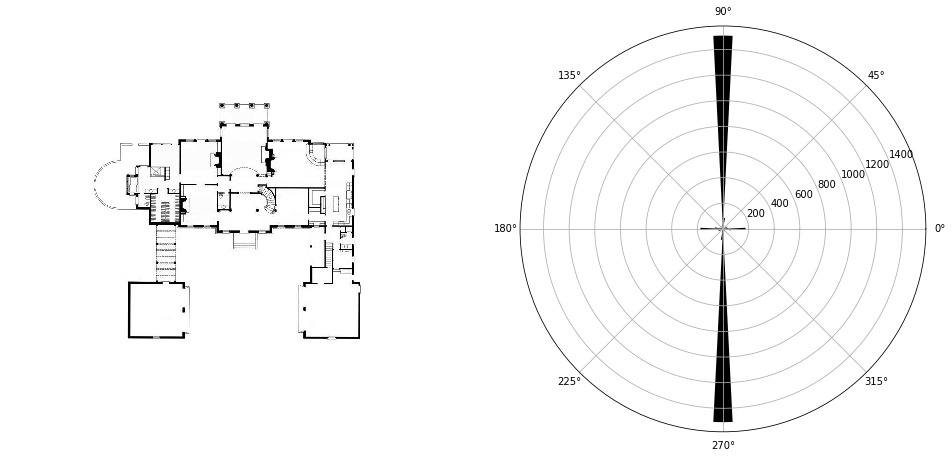

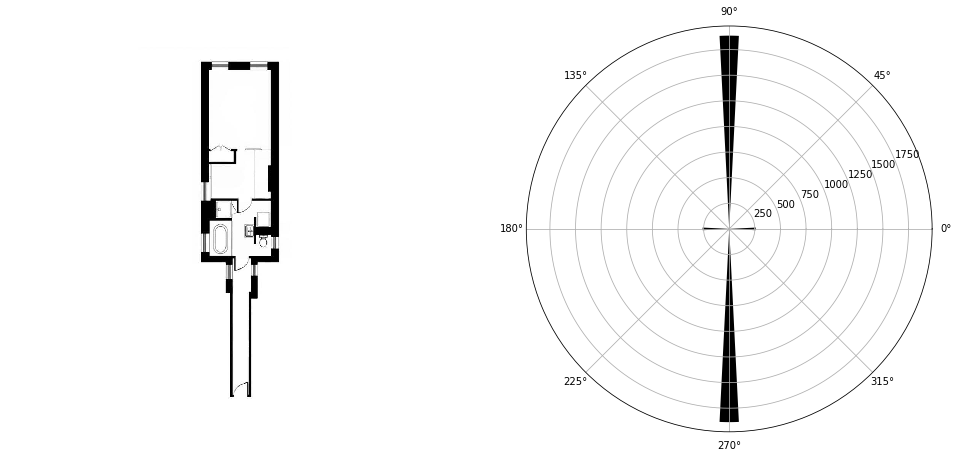

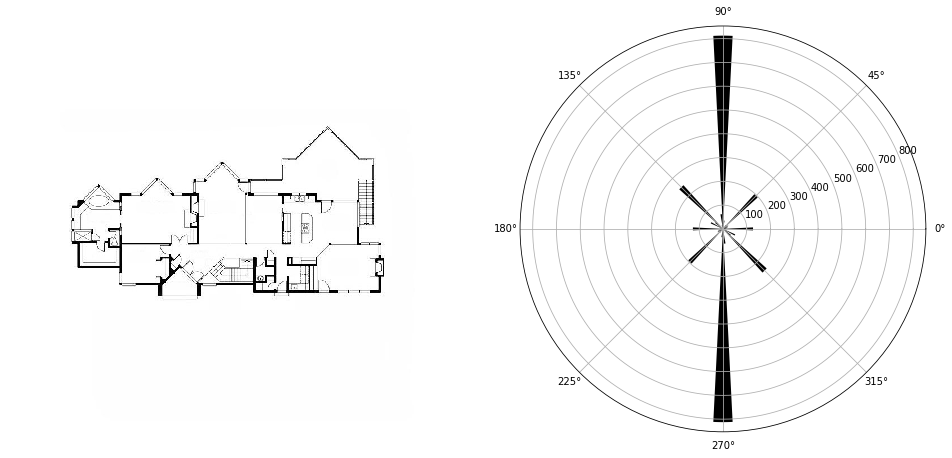

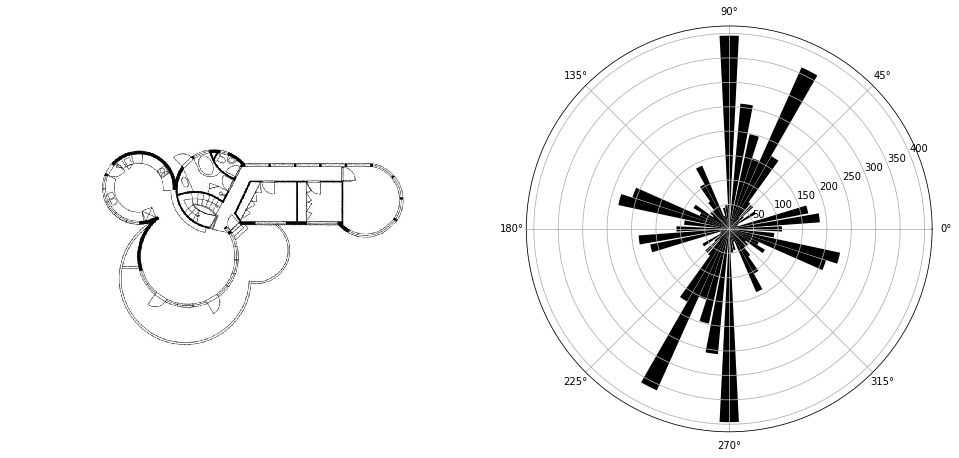

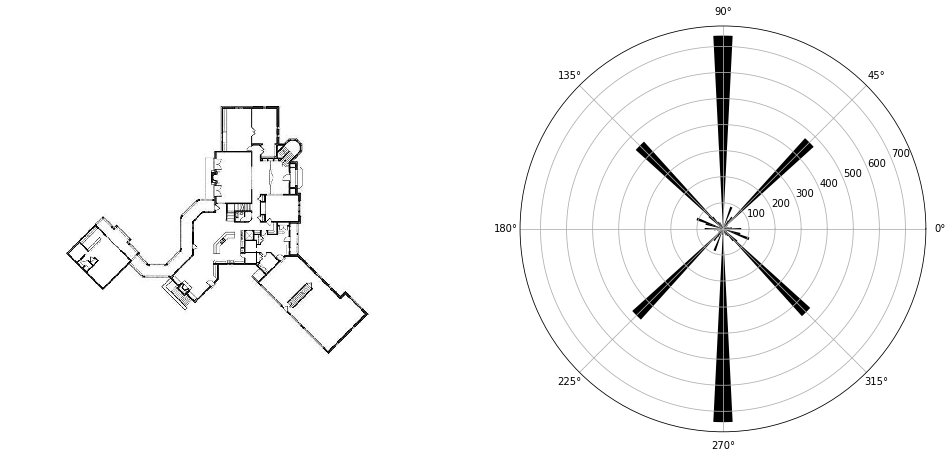

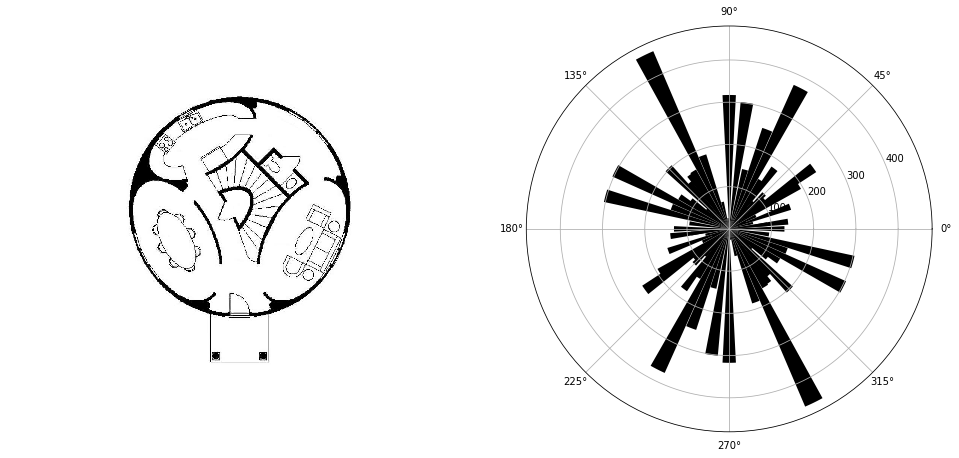

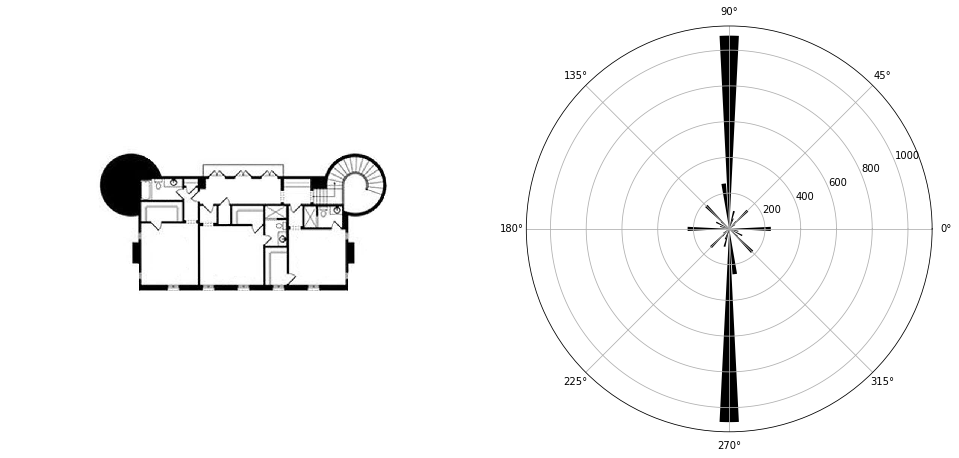

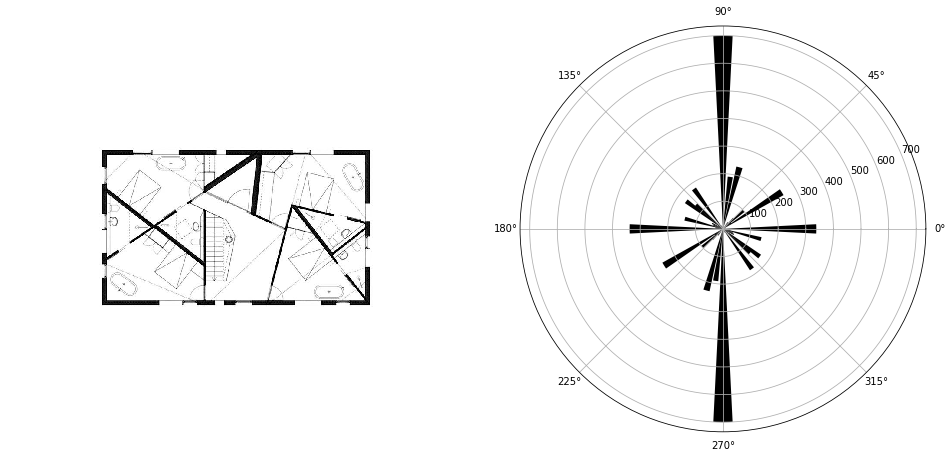

In [13]:
for i in range(25):
    im = cv2.imread("IMG/terrible_plans/"+img_names[i])
    graph_, image_ = get_skeleton(im,print_=False) 
    try:
        unique_angles, cumulative_sum = get_orientation_graph(im, graph_, print_=True , save_=True , im_id=i)
    except:
        pass